In [3]:

!pip install spotipy yellowbrick kaggle


In [4]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances

from yellowbrick.features import Rank2D
from yellowbrick.cluster import KElbowVisualizer

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

import warnings
warnings.filterwarnings("ignore")
np.random.seed(42)


In [6]:
# Cell 2: Load dataset
DATA_PATH = "spotify_dataset.csv"   # your Kaggle file
df = pd.read_csv(DATA_PATH)

print("Shape:", df.shape)
df.head()


Shape: (114000, 21)


,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


In [7]:
# Cell 3: Feature selection

audio_features = [
    "danceability", "energy", "loudness", "speechiness",
    "acousticness", "instrumentalness", "liveness",
    "valence", "tempo"
]

meta_cols = ["track_id", "track_name", "artists", "track_genre"]

df = df[meta_cols + audio_features]
df = df.dropna()

print("After cleaning:", df.shape)
df.head()


After cleaning: (113999, 13)


,track_id,track_name,artists,track_genre,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,5SuOikwiRyPMVoIQDJUgSV,Comedy,Gen Hoshino,acoustic,0.676,0.4610,-6.746,0.1430,0.0322,0.000001,0.3580,0.715,87.917
1,4qPNDBW1i3p13qLCt0Ki3A,Ghost - Acoustic,Ben Woodward,acoustic,0.420,0.1660,-17.235,0.0763,0.9240,0.000006,0.1010,0.267,77.489
2,1iJBSr7s7jYXzM8EGcbK5b,To Begin Again,Ingrid Michaelson;ZAYN,acoustic,0.438,0.3590,-9.734,0.0557,0.2100,0.000000,0.1170,0.120,76.332
3,6lfxq3CG4xtTiEg7opyCyx,Can't Help Falling In Love,Kina Grannis,acoustic,0.266,0.0596,-18.515,0.0363,0.9050,0.000071,0.1320,0.143,181.740
4,5vjLSffimiIP26QG5WcN2K,Hold On,Chord Overstreet,acoustic,0.618,0.4430,-9.681,0.0526,0.4690,0.000000,0.0829,0.167,119.949


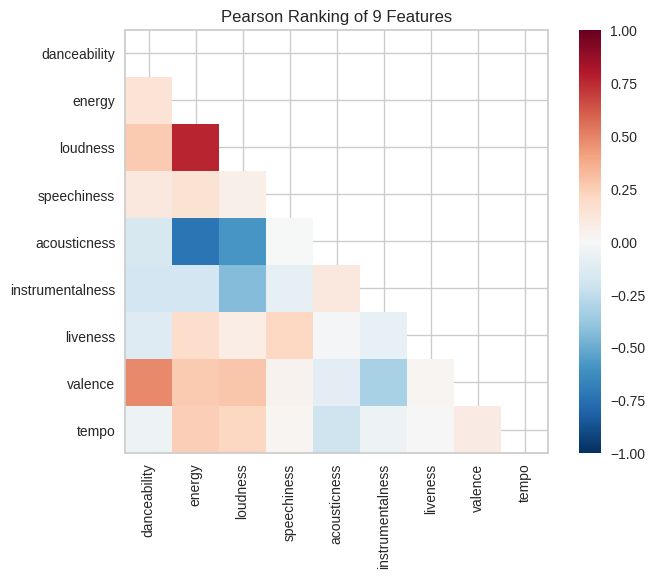

<Axes: title={'center': 'Pearson Ranking of 9 Features'}>

In [8]:
# Cell 4: Correlation analysis

X = df[audio_features]

visualizer = Rank2D(features=audio_features, algorithm="pearson")
visualizer.fit(X)
visualizer.transform(X)
visualizer.show()


In [9]:
# Cell 5: Standardize features

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


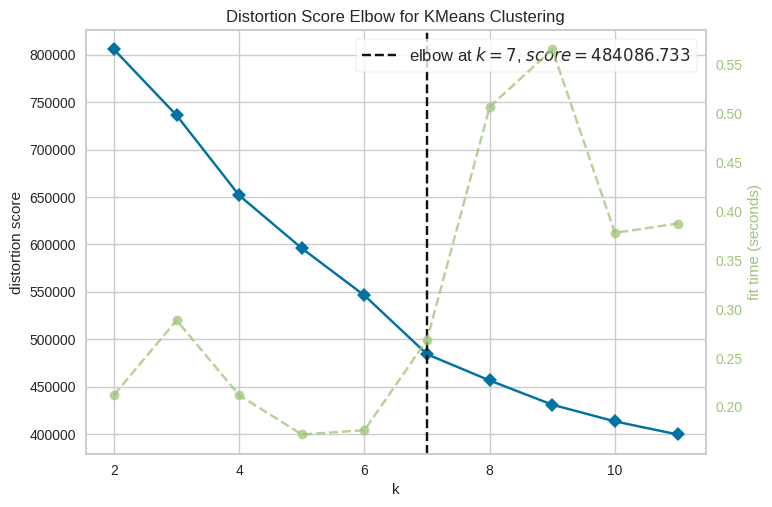

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [10]:
# Cell 6: Elbow method

model = KMeans(random_state=42)
visualizer = KElbowVisualizer(model, k=(2,12))
visualizer.fit(X_scaled)
visualizer.show()


In [11]:
# Cell 7: K-Means clustering

K = 8
kmeans = KMeans(n_clusters=K, random_state=42)
df["cluster"] = kmeans.fit_predict(X_scaled)

df[["track_name", "artists", "track_genre", "cluster"]].head()


,track_name,artists,track_genre,cluster
0,Comedy,Gen Hoshino,acoustic,4
1,Ghost - Acoustic,Ben Woodward,acoustic,5
2,To Begin Again,Ingrid Michaelson;ZAYN,acoustic,2
3,Can't Help Falling In Love,Kina Grannis,acoustic,5
4,Hold On,Chord Overstreet,acoustic,5


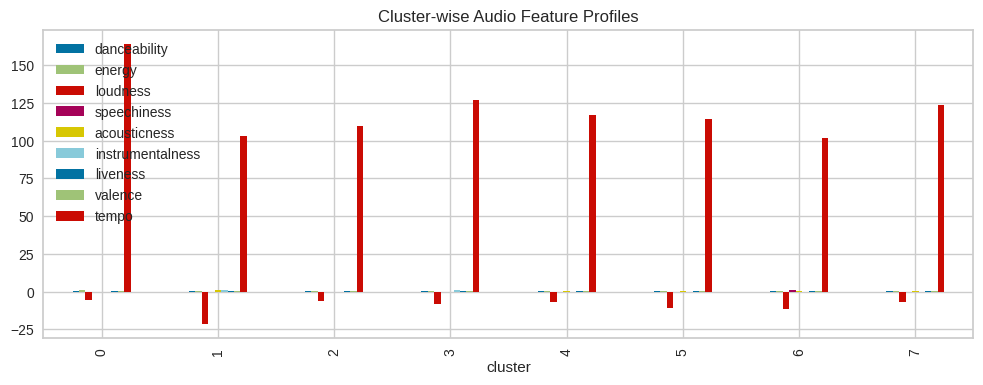

In [12]:
# Cell 8: Cluster profiles

cluster_profile = df.groupby("cluster")[audio_features].mean()
cluster_profile
cluster_profile.plot(kind="bar", figsize=(12,4))
plt.title("Cluster-wise Audio Feature Profiles")
plt.show()


In [13]:
# Cell 9: Recommendation function

def recommend_songs(track_name, n_recommendations=5):
    track_row = df[df["track_name"].str.lower() == track_name.lower()]

    if track_row.empty:
        return "Track not found"

    cluster = track_row.iloc[0]["cluster"]
    cluster_tracks = df[df["cluster"] == cluster]

    track_features = scaler.transform(track_row[audio_features])
    cluster_features = scaler.transform(cluster_tracks[audio_features])

    distances = euclidean_distances(track_features, cluster_features)[0]

    cluster_tracks = cluster_tracks.copy()
    cluster_tracks["distance"] = distances

    recs = cluster_tracks.sort_values("distance").iloc[1:n_recommendations+1]
    return recs[["track_name", "artists", "track_genre"]]


In [14]:
# Cell 10: Example recommendation

recommend_songs("Blinding Lights", n_recommendations=5)


,track_name,artists,track_genre
38541,Mob Rule,Bad//Dreems,garage
444,You Are the Best Thing,Ray LaMontagne,acoustic
61565,PLAYER,PASSEPIED,j-idol
69744,Vaanampaadiyin,Sujatha,malay
34683,1+1,Ready Kirken,folk
